<a href="https://colab.research.google.com/github/scaairesearch/da_cv_fer/blob/main/da_cv_fer_sfew_expw_v15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Changes :
- New Augmentations - randromcropresize and cutout
- Use of BespokeDANN without attention
- Epochs reduced from 100 to 60

Observations:
- The VAL loss is not stable, it rises up after getting a minima
- appears that accuracy NON-DANN () > EWC () > DANN ()
  
  - non-dann (202/419 (48.21%)) - dann (189/419 (45.11%)) - EWC DANN (196/419 (46.78%))
- The training accuracy is around 94%, which means less overfit. May increase EPOCHs in the next interation

Models:
- 13_02 (files manually changed from 14_02 to 13_02)


## Cloning repository
Importing files regarding dataset, model, mains and utils

In [51]:
!git clone https://github.com/scaairesearch/da_cv_fer
import os
os.getcwd()
os.chdir('da_cv_fer')

Cloning into 'da_cv_fer'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 277 (delta 32), reused 68 (delta 32), pack-reused 209
Receiving objects: 100% (277/277), 13.93 MiB | 18.27 MiB/s, done.
Resolving deltas: 100% (146/146), done.


Installing dependencies

In [52]:
!pip install -q -r requirements.txt # -q is for quiet install
# for some reason the below does not get installed with requirements
!pip install -q opendatasets
!pip install -q facenet_pytorch

ERROR: Could not find a version that satisfies the requirement pywin32==306 (from versions: none)
ERROR: No matching distribution found for pywin32==306


## Libraries and Initializations

In [53]:
# Installs from files
from da_cv_fer.data_config import DataConfig
from da_cv_fer.ds_sfew import DatasetSFEW
from da_cv_fer.ds_sfew_crop import DatasetSFEWCROP
from da_cv_fer.ds_expw_crop import EXPWCROP
from da_cv_fer.ds_expw import EXPW
from da_cv_fer.utils import *
from da_cv_fer.model_DANN import DANN
from da_cv_fer.model_DANN_Bespoke import DANNBespoke
from da_cv_fer.run_config import RunConfig
from da_cv_fer.train import *
import os
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm import tqdm # for beautiful model training updates

import matplotlib.pyplot as plt # for plots

import time
from pathlib import Path

from copy import deepcopy
import numpy as np


### Initializing configs

In [54]:
#initializing dataconfig, it tells us about dataset configuration and directory structure
dataconfig = DataConfig()

## SFEW Dataset

Creating dataloader objects.

It copies files from a google drive, unzips it and sets that for use

details: da_cv_fer.ds_sfew.DatasetSFEW

In [55]:
# Mounting Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [56]:
# sfew = DatasetSFEW()
sfew = DatasetSFEWCROP()
sfew_train_loader, sfew_val_loader = sfew.get_dataloader()
print(f' length of SFEW dataset : {len(sfew_train_loader.dataset)}')

 self.BASE_PATH -dataset, 
 self.EXTRACT_DIR-dataset/sfew,
 self.ZIP_FILE_PATH - dataset/SFEW_2.zip 
Directory dataset/sfew created successfully.
No files (including zip file) found in dataset/sfew.Copying file
Starting File copying from /content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip to dataset/sfew
File copied successfully from /content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip to dataset/sfew
Initiating extraction of dataset/sfew/SFEW_2.zip to dataset/sfew
...completed for dataset/sfew/SFEW_2.zip
dataset/sfew/Train Angry.zip Angry
...completed for dataset/sfew/Train/Angry.zip
dataset/sfew/Train Neutral.zip Neutral
...completed for dataset/sfew/Train/Neutral.zip
dataset/sfew/Train Sad.zip Sad
...completed for dataset/sfew/Train/Sad.zip
dataset/sfew/Train Disgust.zip Disgust
...completed for dataset/sfew/Train/Disgust.zip
dataset/sfew/Train Happy.zip Happy
...completed for dataset/sfew/Train/Happy.zip
dataset/sfew/Train Surprise.zip Surprise
...completed for dataset/sfew/Train/Surpri

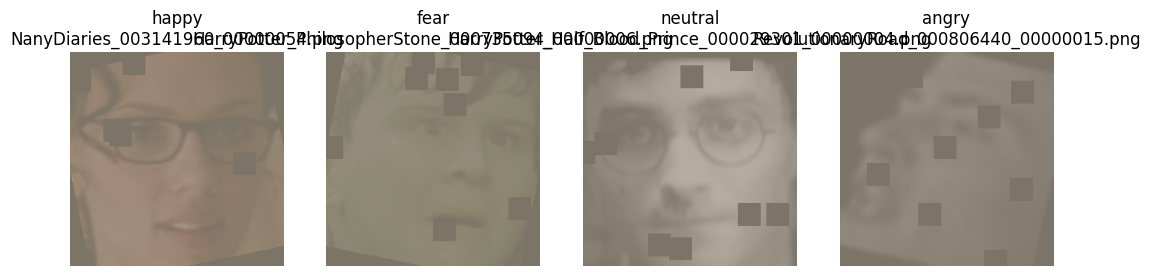

In [57]:
show_batch(sfew_train_loader,sfew.labels,4)

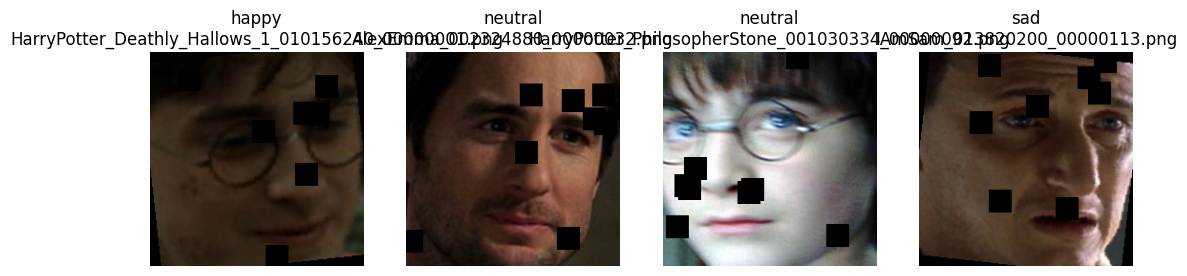

In [58]:
show_batch(sfew_train_loader,sfew.labels,4, normalized = False)

## EXPW Dataset
Creating dataset and dataloader objects.
Split into train and val.

`details: da_cv_fer.ds_expw.EXPW`
<br>
Please be patient, it takes around 3 minutes to download data set

In [ ]:
# expw_obj = EXPW()
expw_obj = EXPWCROP()

expw_train_ds, expw_val_ds = expw_obj.get_dataset()
expw_train_loader, expw_val_loader = expw_obj.get_dataloader()
print(f' length of EXPW dataset : {len(expw_train_loader.dataset)} , {len(expw_train_ds)}')

desitination file path = dataset/expwds/expwds.zip
in EXPW()...
Directory dataset/expwds created successfully.


100%|██████████| 7.68G/7.68G [01:46<00:00, 77.2MB/s]



File downloaded successfully from https://www.kaggle.com/datasets/mohammedaaltaha/expwds to dataset/expwds/expwds.zip
Unzipped Files already exist in dataset/expwds, not extracted
Directory created: dataset/expwds/cropped
**** dataset/expwds/cropped is empty***

 


KeyboardInterrupt: 

In [ ]:
show_batch(expw_train_loader,expw_train_ds.labels,3)

In [ ]:
show_batch(expw_train_loader,expw_train_ds.labels,3, normalized = False)

## Creating Dataloaders for source and target

In [ ]:
sfew_loader = {'name': 'sfew',
               'train':sfew_train_loader,
               'val':sfew_val_loader
               }
data_loader = {'source' : sfew_loader}
source_name = data_loader['source']['name']


In [ ]:
sfew_loader = {'name': 'sfew',
               'train':sfew_train_loader,
               'val':sfew_val_loader
               }

expw_loader = {'name': 'expw',
               'train':expw_train_loader,
               'val':expw_val_loader
               }

data_loader = {'source' : sfew_loader,
               'target' : expw_loader}

source_name = data_loader['source']['name']
target_name = data_loader['target']['name']

## Initializing Model
details are present in `model_DANN`

In [ ]:
model = DANNBespoke(num_classes=7,backbone='mobilenet', attention=False) #DANN(num_classes=7,backbone='resnet18', dropout=0.1)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = model.to(device)

Running model for single run. checking output shapes

In [ ]:
for usage, dict_data_loader in data_loader.items(): ## {'source' : sfew_loader,'target' : expw_loader}
    print('-'*80)
    print(usage)
    for k, v in dict_data_loader.items(): # {'name': 'sfew','train':sfew_train_loader,'val':sfew_val_loader}
      if k == 'name':
        print (f'--------{k} of dataset : {v}--------')
      else:
        print (f'   --------type : {k}--------')
        batch = next(iter(v)) # it may be possible that some datasets have more than 2 outputs, so this strategy is safe
        images, labels = batch[0].to(device), batch[1].to(device)
        print( "Input:\n","Input Image: ",images.shape, ", labels: ",labels.shape)

        x_labels, x_domains, x_features = model(images) # forward pass
        print("Output:\n", "labels: ", x_labels.shape, ", domains: ",x_domains.shape, ", features: ", x_features.shape)


In [ ]:
# #@title Weight Initialization

# # initializating weights using xavier normal
# def weights_init(m):
#     if isinstance(m, nn.Conv2d):
#       nn.init.xavier_normal_(m.weight)
#     elif isinstance(m, nn.Linear):
#       nn.init.xavier_normal_(m.weight)
#       nn.init.zeros_(m.bias)

# # initializating weights using xavier normal
# def weights_init(m):
#     if isinstance(m, nn.Conv2d):
#       # nn.init.xavier_normal_(m.weight)
#       pass # not initialising Conv layers as they are pretrained
#     elif isinstance(m, nn.Linear):
#       nn.init.xavier_normal_(m.weight) # Linear layers are added on
#       nn.init.zeros_(m.bias)

## Non DANN: Training, Validating, Saving

### Early Stopping Scheduler - ReduceLRonPlateau

In [ ]:
# def early_stopping_difference(list_loss: list, patience = 5, difference = 0.0003):
#   if len(list_loss) > patience:
#     reverse_list_loss = list_loss[::-1]
#     reverse_list_loss = reverse_list_loss[0:patience+1]
#     for index in range(0,len(reverse_list_loss)-1):
#       if abs(reverse_list_loss[index] - reverse_list_loss[index+1]) > difference:
#         return False
#     return True
#   else:
#     return False

Configuration towards execution

In [ ]:
runconfig = RunConfig()
device = runconfig.device

non_dann_model = DANNBespoke(num_classes=7,backbone='mobilenet', attention=False) #DANN(num_classes=7, backbone = 'resnet18')
non_dann_model = non_dann_model.to(device)
best_non_dann_model = DANNBespoke(num_classes=7,backbone='mobilenet', attention=False)# DANN(num_classes=7, backbone = 'resnet18').to(device)
# non_dann_model.apply(weights_init) # initializing model, only linear layers

#learning rate
lr = float(runconfig.inital_lr)

# Epochs
EPOCHS = runconfig.NUM_EPOCHS
# EPOCHS = 5 #override
print("EPOCHS", EPOCHS)

# ReduceLRonPlateau Scheduler Params
scheduler_patience = runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = runconfig.early_stop_patience
early_stop_difference = runconfig.early_stop_difference

# optimizer
optimizer = optim.SGD(non_dann_model.parameters(), lr = lr, momentum = 0.9)

# Set up the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              min_lr=1e-6,
                              verbose= True)

# Initialize variables to track the best validation loss and the best model state
best_val_loss = float('inf')
best_val_acc = 0
best_model_state = None

# loss functions
criterion_class = (runconfig.criterion_class).to(device=device)
criterion_domain = (runconfig.criterion_domain).to(device=device)

# loss accumulation
train_losses = [] # to capture train losses over training epochs
val_losses = [] # to capture validation loss over epochs
lr_schedule = [] # to capture learning rate over epochs
epoch_converge = 0 #TODO: run config based

In [20]:
# Training block
print('------ Training started for Non DANN Model ---- ')
print(f'starting LR : {lr}')
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, " of ", EPOCHS)

    #Train Model
    avg_epoch_loss, curr_lr = train_model(model = non_dann_model,
                                          device = device,
                                          data_loader = data_loader['source']['train'],
                                          optimizer = optimizer,
                                          epoch = epoch,
                                          class_loss_function = criterion_class)
    train_losses.append(avg_epoch_loss)
    lr_schedule.append(curr_lr)

    #Adding Scheduler #TODO: ADD SCHEDULER
    scheduler.step(avg_epoch_loss) #applying scheduler on training loss

    #Validate Model
    correct, avg_epoch_val_loss = test_model(model= non_dann_model,
                                    device= device,
                                    data_loader = data_loader['source']['val'],
                                    class_loss_function = criterion_class
                                    )

    val_losses.append(avg_epoch_val_loss)
    # # Check if the current model has the best validation loss
    # print(f'Last Epoch Val Loss = {avg_epoch_val_loss} | Best Val Loss = {best_val_loss}' )
    # if avg_epoch_val_loss < best_val_loss:
    #   best_val_loss = avg_epoch_val_loss
    #   # save the current model state as the best model state
    #   best_model_state = deepcopy(non_dann_model.state_dict())
    #   print(f'Updated the best model with validation loss: {best_val_loss}\n')

    # check if the current model has the best accuracy
    print (f'last correct ={correct} | best correct = {best_val_acc}')
    if correct > best_val_acc:
      best_val_acc = correct
      # save the current model state as the best model state
      best_model_state = deepcopy(non_dann_model.state_dict())
      print(f'Updated the best model with correct: {correct}\n')


    if early_stopping_difference(val_losses,
                                 patience = early_stop_patience,
                                 difference= early_stop_difference):
      print (f'-------Early Stopping at epoch {epoch+1}---')
      epoch_converge = epoch+1
      break

## using params of best model to update model
if best_model_state: # only update if best model has been saved, else the last one would be picked up
  # best_non_dann_model.load_state_dict(best_model_state)
  non_dann_model.load_state_dict(best_model_state)
  print('Best model loaded')


print(f'Validation results with {source_name}')

correct, test_loss_source = test_model(model= non_dann_model, #best_non_dann_model, #non_dann_model,
                                    device= device,
                                    data_loader = data_loader['source']['val'], # source val loader
                                    class_loss_function = criterion_class)

print(f'Test results with {target_name}')
correct, test_loss_target = test_model(model= non_dann_model, #best_non_dann_model, #non_dann_model,
                                    device= device,
                                    data_loader = data_loader['target']['val'], # target val loader
                                    class_loss_function = criterion_class)

dict_non_dann_losses = {'train_losses' : train_losses,
                                       'val_losses': val_losses,
                                       'test_loss_source' : test_loss_source,
                                       'test_loss_target' : test_loss_target,
                                       'epoch_convergence' : epoch_converge,
                                       'lr': lr_schedule}




Test / Val: Average loss: 0.1348, Accuracy: 184/419 (43.91%)

last correct =184 | best correct = 202
EPOCH: 49  of  60
epoch = 49...in training function


Loss=1.7556939125061035 Accuracy=818/913(89.59%) Epoch Avg loss=0.02118461 LR=0.001000: 100%|██████████| 58/58 [00:11<00:00,  5.09it/s]


Test / Val: Average loss: 0.1367, Accuracy: 194/419 (46.30%)

last correct =194 | best correct = 202
EPOCH: 50  of  60
epoch = 50...in training function


Loss=0.12022431939840317 Accuracy=826/913(90.47%) Epoch Avg loss=0.01841571 LR=0.001000: 100%|██████████| 58/58 [00:11<00:00,  5.04it/s]


Test / Val: Average loss: 0.1432, Accuracy: 182/419 (43.44%)

last correct =182 | best correct = 202
EPOCH: 51  of  60
epoch = 51...in training function


Loss=0.5003403425216675 Accuracy=837/913(91.68%) Epoch Avg loss=0.01708457 LR=0.001000: 100%|██████████| 58/58 [00:11<00:00,  5.16it/s]


Test / Val: Average loss: 0.1424, Accuracy: 178/419 (42.48%)

last correct =178 | best correct = 202
EPOCH: 52  of  60
epoch = 52...in training function


Loss=1.149718999862671 Accuracy=835/913(91.46%) Epoch Avg loss=0.01660810 LR=0.001000: 100%|██████████| 58/58 [00:11<00:00,  5.05it/s]


Test / Val: Average loss: 0.1491, Accuracy: 186/419 (44.39%)

last correct =186 | best correct = 202
EPOCH: 53  of  60
epoch = 53...in training function


Loss=2.0607974529266357 Accuracy=855/913(93.65%) Epoch Avg loss=0.01391905 LR=0.001000: 100%|██████████| 58/58 [00:10<00:00,  5.43it/s]


Test / Val: Average loss: 0.1512, Accuracy: 184/419 (43.91%)

last correct =184 | best correct = 202
EPOCH: 54  of  60
epoch = 54...in training function


Loss=4.201770782470703 Accuracy=853/913(93.43%) Epoch Avg loss=0.01702160 LR=0.001000: 100%|██████████| 58/58 [00:10<00:00,  5.77it/s]


Test / Val: Average loss: 0.1547, Accuracy: 176/419 (42.00%)

last correct =176 | best correct = 202
EPOCH: 55  of  60
epoch = 55...in training function


Loss=0.49087971448898315 Accuracy=856/913(93.76%) Epoch Avg loss=0.01353025 LR=0.001000: 100%|██████████| 58/58 [00:09<00:00,  5.97it/s]


Test / Val: Average loss: 0.1489, Accuracy: 183/419 (43.68%)

last correct =183 | best correct = 202
EPOCH: 56  of  60
epoch = 56...in training function


Loss=1.6266671419143677 Accuracy=861/913(94.30%) Epoch Avg loss=0.01318536 LR=0.001000: 100%|██████████| 58/58 [00:09<00:00,  6.04it/s]


Test / Val: Average loss: 0.1467, Accuracy: 181/419 (43.20%)

last correct =181 | best correct = 202
EPOCH: 57  of  60
epoch = 57...in training function


Loss=1.4897825717926025 Accuracy=864/913(94.63%) Epoch Avg loss=0.01278127 LR=0.001000: 100%|██████████| 58/58 [00:09<00:00,  6.10it/s]


Test / Val: Average loss: 0.1602, Accuracy: 184/419 (43.91%)

last correct =184 | best correct = 202
EPOCH: 58  of  60
epoch = 58...in training function


Loss=1.2890750169754028 Accuracy=849/913(92.99%) Epoch Avg loss=0.01412975 LR=0.001000: 100%|██████████| 58/58 [00:09<00:00,  6.03it/s]


Test / Val: Average loss: 0.1627, Accuracy: 181/419 (43.20%)

last correct =181 | best correct = 202
EPOCH: 59  of  60
epoch = 59...in training function


Loss=0.2027944028377533 Accuracy=858/913(93.98%) Epoch Avg loss=0.01214074 LR=0.001000: 100%|██████████| 58/58 [00:09<00:00,  5.84it/s]


Test / Val: Average loss: 0.1562, Accuracy: 175/419 (41.77%)

last correct =175 | best correct = 202
EPOCH: 60  of  60
epoch = 60...in training function


Loss=1.4155733585357666 Accuracy=862/913(94.41%) Epoch Avg loss=0.01289316 LR=0.001000: 100%|██████████| 58/58 [00:10<00:00,  5.64it/s]


Test / Val: Average loss: 0.1599, Accuracy: 183/419 (43.68%)

last correct =183 | best correct = 202
Best model loaded
Validation results with sfew
Test / Val: Average loss: 0.0969, Accuracy: 202/419 (48.21%)

Test results with expw
Test / Val: Average loss: 0.2271, Accuracy: 4/34 (11.76%)



In [21]:
#checking if the models are same weights, i.e. copy has worked fine
# for p1, p2 in zip(non_dann_model.to(device).parameters(), best_non_dann_model.to(device).parameters()):
#     if p1.data.ne(p2.data).sum() > 0:
#         print ('False')
#         break
# print ('True')

In [22]:
print(dict_non_dann_losses)

{'train_losses': [0.12121184, 0.11966402, 0.11751529, 0.11667188, 0.11376412, 0.1101666, 0.10674262, 0.10589259, 0.10306433, 0.10030083, 0.09515162, 0.09478426, 0.09177241, 0.08823302, 0.08211172, 0.08075068, 0.0782507, 0.07295504, 0.07362588, 0.07023405, 0.06825633, 0.0662325, 0.06153446, 0.06225355, 0.05576893, 0.05428385, 0.05322154, 0.04957858, 0.047403, 0.04829588, 0.0494081, 0.04288357, 0.04261221, 0.03919878, 0.03755825, 0.03889034, 0.03879125, 0.03821982, 0.03411993, 0.03263812, 0.03296506, 0.03057475, 0.03134433, 0.02576569, 0.02990705, 0.02746173, 0.03193358, 0.02664242, 0.02118461, 0.01841571, 0.01708457, 0.0166081, 0.01391905, 0.0170216, 0.01353025, 0.01318536, 0.01278127, 0.01412975, 0.01214074, 0.01289316], 'val_losses': [0.12297388904134528, 0.1211424676216872, 0.12282179904154775, 0.12009195040973672, 0.1286100109323397, 0.11782418970276462, 0.1131173927061313, 0.11255050928894261, 0.11088618799723987, 0.10720744195587595, 0.11170388662160723, 0.10476253026994145, 0.104

In [23]:
# #@title Plotting Training and Validation Loss Function
# def plot_loss_curves(dict_losses, mode = "train_losses"):
#     fig=plt.figure(figsize=(10,20))
#     fig.add_subplot(5, 1, 2)
#     # for embedding in dict_emb_file.keys():
#     list1_to_plot= dict_losses[mode]
#     plt.plot(range(1,len(list1_to_plot)+1),list1_to_plot, label = 'Non DANN ' + 'SFEW')
#     plt.xlabel('number of epochs', fontsize=10)
#     plt.ylabel(str(mode), fontsize=10)
#     plt.legend(loc = 'upper right')
#     plt.title(" "+mode)
#     plt.show()

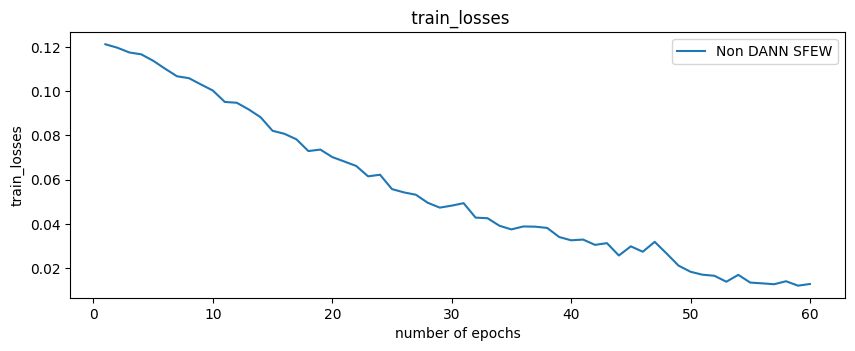

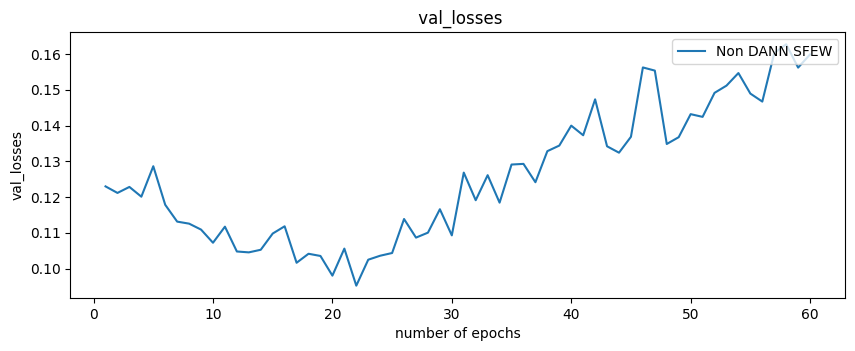

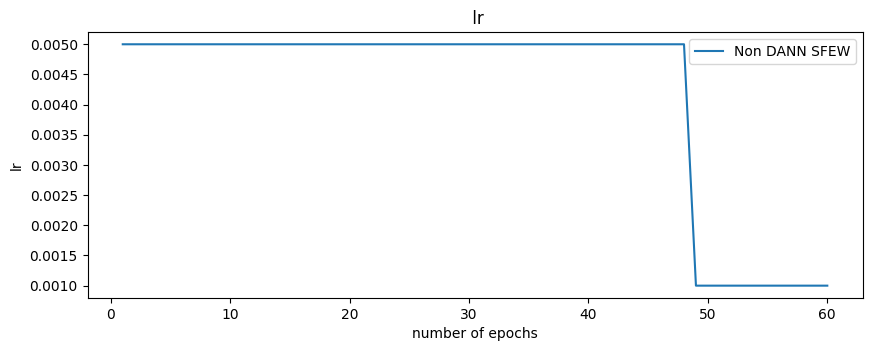

In [24]:
plot_loss_curves(dict_non_dann_losses,mode='train_losses')
plot_loss_curves(dict_non_dann_losses,mode='val_losses')
plot_loss_curves(dict_non_dann_losses,mode='lr')

### Saving NON DANN Model

In [25]:
MODEL_DIR = dataconfig.MODEL_DIR
NON_DANN_SFEW_DIR = dataconfig.NON_DANN_SFEW_DIR
SPECIFIC_MODEL_DIR = Path(os.path.join(MODEL_DIR, f'non_dann_{source_name}_{target_name}'))
print(MODEL_DIR, NON_DANN_SFEW_DIR, SPECIFIC_MODEL_DIR)

/content/gdrive/MyDrive/CV_FER/models /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew_expw


In [26]:
model_name = f'non_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}.pt' #"non_dann_sfew_" +str(time.strftime("%d_%m"))+ ".pt"
# dataconfig = DataConfig()
# NON_DANN_SFEW_DIR = dataconfig.NON_DANN_SFEW_DIR
if not SPECIFIC_MODEL_DIR.exists():
    # Create the directory
    SPECIFIC_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {SPECIFIC_MODEL_DIR} created successfully.')
else:
    print(f'Directory {SPECIFIC_MODEL_DIR} already exists.')

torch.save(non_dann_model.state_dict(), Path(SPECIFIC_MODEL_DIR,model_name))

Directory /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew_expw already exists.


In [27]:
# #@title Plotting Training and Validation Loss Function
# def plot_loss_curves(dict_non_dann_losses_list, mode = "train_losses"):
#     fig=plt.figure(figsize=(10,20))
#     fig.add_subplot(5, 1, 2)
#     # for embedding in dict_emb_file.keys():
#     list1_to_plot= dict_non_dann_losses_list[mode]
#     plt.plot(range(1,len(list1_to_plot)+1),list1_to_plot, label = 'Non DANN ' + 'SFEW')
#     plt.xlabel('number of epochs', fontsize=10)
#     plt.ylabel(str(mode), fontsize=10)
#     plt.legend(loc = 'upper right')
#     plt.title(" "+mode)
#     plt.show()

In [28]:
# plot_loss_curves(dict_non_dann_losses_list,mode='train_losses')
# plot_loss_curves(dict_non_dann_losses_list,mode='val_losses')
# plot_loss_curves(dict_non_dann_losses_list,mode='lr')

In [29]:
# model_name = model_name #"non_dann_sfew_19_12.pt"

## Loading NON DANN Model for DANN and DANN EWC


In [30]:
model_name = f'non_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}.pt' # Typical - non_dann_sfew_expw_30_01.pt This may change, use specific model name if required4
model_name

'non_dann_sfew_expw_14_02.pt'

In [31]:
# best_model_dann = DANN(num_classes=7, backbone = 'resnet18').to(device) # skeleton copy
# best_model_dann_ewc = DANN(num_classes=7, backbone = 'resnet18').to(device) # skeleton copy
# model_dann = deepcopy(non_dann_model) # saves training time - check with all
# model_dann_ewc = deepcopy(non_dann_model) # saves training time - check with all

In [32]:
# from data_config import DataConfig
dataconfig_1 = DataConfig()
MODEL_DIR = dataconfig_1.MODEL_DIR

MODEL_PATH = Path(os.path.join(MODEL_DIR, f'non_dann_{source_name}_{target_name}', model_name))

loaded_model_non_dann =  DANNBespoke(num_classes=7,backbone='mobilenet', attention=False)# DANN(num_classes=7, backbone = 'resnet18') # skeleton copy
best_model_dann = DANNBespoke(num_classes=7,backbone='mobilenet', attention=False).to(device) # DANN(num_classes=7, backbone = 'resnet18').to(device) # skeleton copy
best_model_dann_ewc = DANNBespoke(num_classes=7,backbone='mobilenet', attention=False).to(device) #DANN(num_classes=7, backbone = 'resnet18').to(device) # skeleton copy

loaded_model_non_dann.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device(device)))

# loaded_model_non_dann.load_state_dict(torch.load(Path(NON_DANN_SFEW_DIR, model_name),map_location=torch.device(device)))
model_dann = deepcopy(loaded_model_non_dann) # saves training time - check with all
model_dann_ewc = deepcopy(loaded_model_non_dann) # saves training time - check with all


# print(model_dann)

feature extractor backbone created using mobilenet model
feature extractor backbone created using mobilenet model
feature extractor backbone created using mobilenet model


In [33]:
# #checking if the models are same weights, i.e. copy has worked fine
# for p1, p2 in zip(non_dann_model.parameters(), model_dann.parameters()):
#     if p1.data.ne(p2.data).sum() > 0:
#         print ('False')
# print ('True')

## DANN Execution :  Training, Validating, Saving


### DANN Execution Function

In [34]:

def execute_dann(model,
                 device,
                 source_train_loader, source_val_loader,
                 target_train_loader, target_val_loader,
                 optimizer,
                 n_epochs, # total number of epochs (different from individual epoch)
                 class_loss_function = nn.CrossEntropyLoss(),
                 domain_loss_function = nn.BCEWithLogitsLoss(),
                 scheduler = None,
                 early_stop_patience = None,
                 early_stop_difference = None
                 ):

    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    list_lr =[] # to capture lr over epochs
    epoch_converge = 0
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    model = model.to(device)

    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]


    # for best model
    best_model = deepcopy(model).to(device) # for best model
    best_val_loss = float('inf') # Initialize variables to track the best validation loss
    best_val_acc = 0 # Initialize variable to track best accuracy
    best_model_state = None # Initialize variables to track the best model state


    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter (target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0

        for batch_idx in range(max_batches-1):
            p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            alpha = 2. / (1. + np.exp(-10 * p)) - 1
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)

            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)
            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}


            loss_source_class = class_loss_function(source_class_outputs, source_labels) # calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]

            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device)  # Target Image == [0., 1.]
            # print(f' target domain input shape {target_domain_inputs.shape}, output shape {target_domain_outputs.shape}')

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss


            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + loss_source_domain + loss_target_domain
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()

            curr_lr = optimizer.param_groups[0]['lr'] # current learning rate
            list_lr.append(curr_lr)

            # after 10 batches
            if (batch_idx % 10 == 0):
                print("Epoch[{}/{}] Step[{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.2f} / lr={:.6f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha,
                      curr_lr
                      ))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        #Scheduler
        if scheduler:
          scheduler.step(avg_train_task_loss) ## applying scheduler on training loss

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model(model= model,
                                                device= device,
                                                data_loader = source_val_loader,
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)

        # # Check if the current model has the best validation loss
        # print(f'Last Epoch Val Loss = {avg_val_task_loss} | Best Val Loss = {best_val_loss}' )
        # if avg_val_task_loss < best_val_loss:
        #   best_val_loss = avg_val_task_loss
        #   # save the current model state as the best model state
        #   best_model_state = deepcopy(model.state_dict())
        #   print(f'Updated the best model with validation loss: {best_val_loss}\n')

        # check if the current model has the best accuracy
        print (f'last correct ={correct} | best correct = {best_val_acc}')
        if correct > best_val_acc:
          best_val_acc = correct
          # save the current model state as the best model state
          best_model_state = deepcopy(model.state_dict())
          print(f'Updated the best model with correct: {correct}\n')



        #TODO: Early Stopping
        if early_stop_patience and early_stop_difference: # early stopping required
          if early_stopping_difference(val_losses,
                                       patience = early_stop_patience,
                                       difference= early_stop_difference):
            print (f'-------Early Stopping at epoch {epoch+1}---')
            epoch_converge = epoch+1
            break # break from epoch loop


    # Testing when the training is over - completed or early stopped
    ## using params of best model to update model
    if best_model_state: # only update if best model has been saved, else the last one would be picked up
      model.load_state_dict(best_model_state)
      print('Best model loaded')

    correct, test_loss_source = test_model(model= model,
                            device= device,
                            data_loader = source_val_loader, # source val loader
                            class_loss_function = class_loss_function)

    correct, test_loss_target = test_model(model= model,
                            device= device,
                            data_loader = target_val_loader, # target val loader
                            class_loss_function = class_loss_function)

    dict_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        'test_loss_source' : test_loss_source,
                        'test_loss_target' : test_loss_target,
                        'epoch_convergence' : epoch_converge,
                        'list_alpha' : list_alpha,
                        'lr':list_lr}

    print(f'alpha list \n {list_alpha}')
    return model, dict_dann_losses





In [35]:
runconfig = RunConfig()
lr_dann = runconfig.inital_lr
lr_dann = lr_dann #/ 5.0 # OVERRIDE
optimizer_dann = optim.SGD(model_dann.parameters(), lr = lr_dann, momentum = 0.9)
n_epochs = runconfig.EPOCHS

# ReduceLRonPlateau Scheduler Params
scheduler_patience = runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = runconfig.early_stop_patience
early_stop_difference = runconfig.early_stop_difference

# Set up the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer_dann,
                              mode='min',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              min_lr=1e-6,
                              verbose= True)

print(f'------------training started for DANN Model ------------------')

dann_model_trained, dict_dann_losses = execute_dann(model=model_dann,
                                                    device=device,
                                                    source_train_loader = data_loader['source']['train'], #sfew_train_loader,
                                                    source_val_loader = data_loader['source']['val'], #sfew_val_loader,
                                                    target_train_loader = data_loader['target']['train'], #expw_train_loader,
                                                    target_val_loader = data_loader['target']['val'], #expw_val_loader,
                                                    optimizer = optimizer_dann,
                                                    n_epochs = n_epochs,
                                                    class_loss_function = runconfig.criterion_class,
                                                    domain_loss_function = runconfig.criterion_domain,
                                                    scheduler = scheduler,
                                                    early_stop_patience = early_stop_patience,
                                                    early_stop_difference = early_stop_difference
                                                    )

------------training started for DANN Model ------------------
epoch = 1...in DANN execution function
Epoch[1/60] Step[1/41]: loss_total=2.2830 / domain_loss_target=0.6665 / domain_loss_source=0.7214 / task_loss=0.8951 / domain_loss=1.6165 / alpha=0.00 / lr=0.005000
Epoch[1/60] Step[11/41]: loss_total=1.9257 / domain_loss_target=0.6692 / domain_loss_source=0.7208 / task_loss=0.5358 / domain_loss=1.2565 / alpha=0.02 / lr=0.005000
Epoch[1/60] Step[21/41]: loss_total=2.1724 / domain_loss_target=0.6824 / domain_loss_source=0.7023 / task_loss=0.7877 / domain_loss=1.4900 / alpha=0.04 / lr=0.005000
Epoch[1/60] Step[31/41]: loss_total=2.3814 / domain_loss_target=0.6959 / domain_loss_source=0.6908 / task_loss=0.9948 / domain_loss=1.6856 / alpha=0.06 / lr=0.005000
Test / Val: Average loss: 0.1043, Accuracy: 189/419 (45.11%)

last correct =189 | best correct = 0
Updated the best model with correct: 189

epoch = 2...in DANN execution function
Epoch[2/60] Step[1/41]: loss_total=2.8406 / domain_loss

In [36]:
# dict_dann_losses

### DANN Plotting and Validation

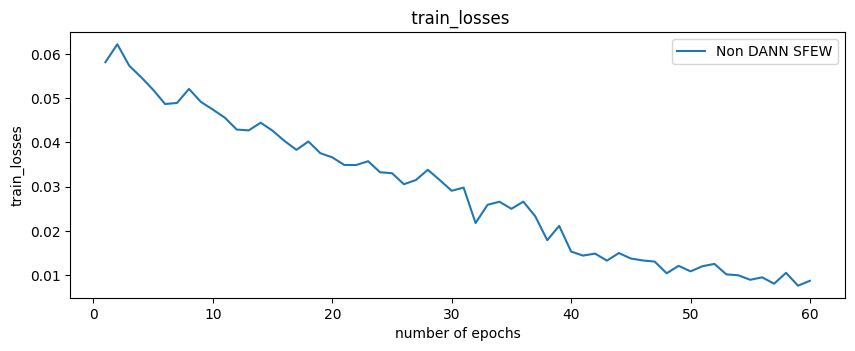

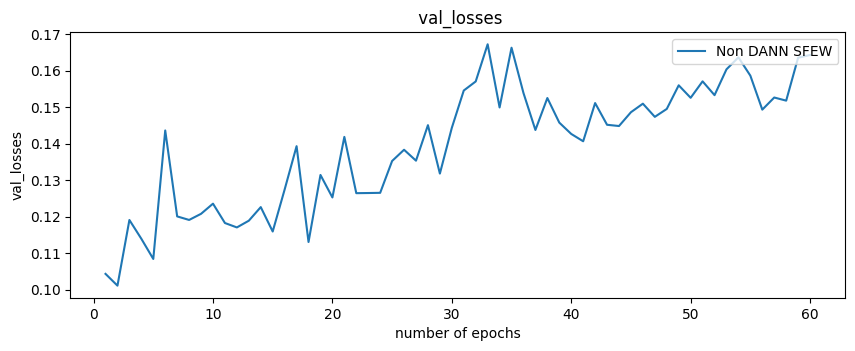

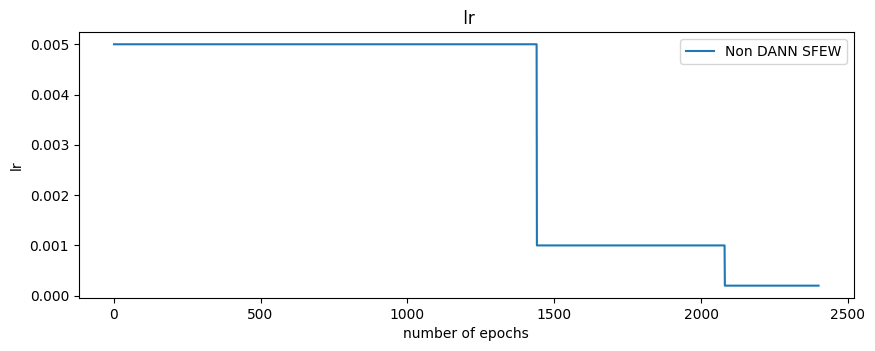

In [37]:
plot_loss_curves(dict_dann_losses,mode='train_losses')
plot_loss_curves(dict_dann_losses,mode='val_losses')
plot_loss_curves(dict_dann_losses,mode='lr')
# plot_loss_curves(dict_dann_losses,mode='list_alpha')


### Saving DANN Model

In [38]:
model_dann

DANNBespoke(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=

In [39]:
dataconfig_1 = DataConfig()
MODEL_DIR = dataconfig_1.MODEL_DIR
MODEL_DIR

PosixPath('/content/gdrive/MyDrive/CV_FER/models')

In [40]:

dann_model_name = f'dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}.pt' # "dann_sfew_expw_" + str(time.strftime("%d_%m")) + ".pt"
print(dann_model_name)

# from data_config import DataConfig
dataconfig_1 = DataConfig()
MODEL_DIR = dataconfig_1.MODEL_DIR

DANN_MODEL_DIR =  Path(os.path.join(MODEL_DIR, f'dann_{source_name}_{target_name}'))
# try:
#     DANN_SFEW_EXPW_DIR = Path(dataconfig_1.DANN_SFEW_EXPW_DIR)
# except:
#     DANN_SFEW_EXPW_DIR =Path(dataconfig_1.MODEL_DIR,"dann_sfew_expw")


if not DANN_MODEL_DIR.exists():
    # Create the directory
    DANN_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {DANN_MODEL_DIR} created successfully.')
else:
    print(f'Directory {DANN_MODEL_DIR} already exists.')


try:
    torch.save(model_dann.state_dict(), Path(DANN_MODEL_DIR,dann_model_name))
    print(f'{dann_model_name} SAVED at {Path(DANN_MODEL_DIR,dann_model_name)}!')
except:
    print(f'Problem in saving {dann_model_name}, NOT SAVED!')


dann_sfew_expw_14_02.pt
Directory /content/gdrive/MyDrive/CV_FER/models/dann_sfew_expw already exists.
dann_sfew_expw_14_02.pt SAVED at /content/gdrive/MyDrive/CV_FER/models/dann_sfew_expw/dann_sfew_expw_14_02.pt!


## DANN EWC : Training, Validating, Saving

In [41]:
# dataconfig_inference = DataConfig()

# # NON DANN
# non_dann_model_sfew_name = 'non_dann_sfew_20_01.pt'
# non_dann_model_inference = DANN(num_classes=7) # skeleton copy
# NON_DANN_SFEW_DIR = dataconfig_inference.NON_DANN_SFEW_DIR # Path(self.MODEL_DIR,"non_dann_sfew")

# try:
#     non_dann_model.load_state_dict(torch.load(Path(NON_DANN_SFEW_DIR, non_dann_model_sfew_name),
#                                                         map_location=torch.device(device)))
#     print(f'{non_dann_model_sfew_name} locked and loaded')
# except:
#     print(f' problem in loading {non_dann_model_sfew_name}')


In [42]:
# model_dann_ewc = non_dann_model # saves training time - check with all


In [43]:
model_dann_ewc

DANNBespoke(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=

### EWC Code
Regularization Penalty

In [44]:

from torch.autograd import Variable
from torch.autograd import Function
from da_cv_fer.run_config import RunConfig

runconfig = RunConfig()
def variable(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return Variable(t, **kwargs)

class EWC(object):
    def __init__(self, model: nn.Module,
                 data_loader: torch.utils.data.DataLoader
                #  dataset: list
                 ,device=device
                 , class_loss_function = runconfig.criterion_class):

        self.model = model
        # print("----------MODEL--------\n",self.model)
        self.dataset = data_loader
        self.device = device
        self.class_loss_function = class_loss_function

        # creating dictionary of params which required grad
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}

        self._means = {}
        for n, p in deepcopy(self.params).items():
            self._means[n] = variable(p.data)

        # print("--------self._means----------------\n", self._means)

        self._precision_matrices = self._diag_fisher()

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)
        # print("--------PRECISION MATRICES----------------\n", precision_matrices)

        self.model.eval()
        for batch in self.dataset:
            self.model.zero_grad()
            images, labels  = variable(batch[0].to(device)), variable(batch[1].to(device))
            class_ouputs, _ , _ = model(images) # class_output, domain_output, features
            task_loss =  self.class_loss_function(class_ouputs,labels)
            task_loss.backward() # only calculating the gradients, not updating it
            # print("--------task loss----------------\n", task_loss)

            for n, p in self.model.named_parameters():
              # if type(p.grad)
              if isinstance(p.grad, type(None)):
                pass # parameter value would remain as it is
              else:
                # print(n,":", type(p.grad))
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

**DANN EWC Object.**

In [45]:
# ewc_object = EWC(deepcopy(model_dann_ewc),
#                  data_loader=data_loader['source']['train'],#sfew_train_loader,
#                  device=device,
#                  class_loss_function=runconfig.criterion_class)

### DANN EWC Execution (training and testing) Function without Learning rate
Training Function

In [46]:
def execute_dann_ewc(model,
                     device,
                     source_train_loader, source_val_loader,
                     target_train_loader, target_val_loader,
                     optimizer,
                     n_epochs, # total number of epochs (different from individual epoch)
                     class_loss_function = nn.CrossEntropyLoss(),
                     domain_loss_function = nn.BCEWithLogitsLoss(),
                     EWC_LAMBDA = 0.4, # to understand regularlization
                     scheduler = None,
                     early_stop_patience = None,
                     early_stop_difference = None
                     ):

    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    list_lr = [] # to capture lr changes across epochs
    epoch_converge = 0
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    existing_model = deepcopy(model)
    model = deepcopy(model).to(device) # copies params from existing model to another one https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492/2
    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]
    #TODO: Scheduler
    # scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, threshold =  0.0005, verbose = True)

    ewc_object = EWC(deepcopy(model),
                     data_loader=source_train_loader,
                     device=device,
                     class_loss_function=class_loss_function) # instantiating EWC object, we would use this object for understanding penalty


    # for best model
    best_model = deepcopy(model).to(device) # for best model
    best_val_loss = float('inf') # Initialize variables to track the best validation loss
    best_model_state = None # Initialize variables to track the best model state
    best_val_acc = 0 # Initialize variables to track the best accuracy


    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in EWC DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter(target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0

        for batch_idx in range(max_batches-1):
            p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            alpha = 2. / (1. + np.exp(-10 * p)) - 1
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)

            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)
            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            # Calculating source class loss, regularlized by EWC
            loss_source_class = class_loss_function(source_class_outputs, source_labels) + EWC_LAMBDA * ewc_object.penalty(model)# calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]

            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device) # Target Image == [0., 1.]

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss


            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + loss_source_domain + loss_target_domain
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()

            curr_lr = optimizer.param_groups[0]['lr'] # current learning rate
            list_lr.append(curr_lr)


            # after 10 batches
            if (batch_idx % 50 == 0):
                print("Epoch [{}/{}] Step [{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.4f} / lr={:.6f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha,
                      curr_lr
                      ))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        #Scheduler
        if scheduler:
          scheduler.step(avg_train_task_loss) ## applying scheduler on training loss

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model(model= model,
                                                device= device,
                                                data_loader = source_val_loader,
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)

        # # Check if the current model has the best validation loss
        # print(f'Last Epoch Val Loss = {avg_val_task_loss} | Best Val Loss = {best_val_loss}' )
        # if avg_val_task_loss < best_val_loss:
        #   best_val_loss = avg_val_task_loss
        #   # save the current model state as the best model state
        #   best_model_state = deepcopy(model.state_dict())
        #   print(f'Updated the best model with validation loss: {best_val_loss}\n')

        # check if the current model has the best accuracy
        print (f'last correct ={correct} | best correct = {best_val_acc}')
        if correct > best_val_acc:
          best_val_acc = correct
          # save the current model state as the best model state
          best_model_state = deepcopy(model.state_dict())
          print(f'Updated the best model with correct: {correct}\n')

        #TODO: Early Stopping
        if early_stop_patience and early_stop_difference: # early stopping required
          if early_stopping_difference(val_losses,
                                       patience = early_stop_patience,
                                       difference= early_stop_difference):
            print (f'-------Early Stopping at epoch {epoch+1}---')
            epoch_converge = epoch+1
            break # break from epoch loop

    # Testing when the training is over - completed or early stopped

    ## using params of best model to update model
    if best_model_state: # only update if best model has been saved, else the last one would be picked up
      model.load_state_dict(best_model_state)
      print('Best model loaded')

    correct_source, test_loss_source = test_model(model= model,
                            device= device,
                            data_loader = source_val_loader, # source val loader
                            class_loss_function = class_loss_function)

    accuracy_source = correct_source / len(source_val_loader.dataset)

    correct_target, test_loss_target = test_model(model= model,
                            device= device,
                            data_loader = target_val_loader, # target val loader
                            class_loss_function = class_loss_function)

    accuracy_target = correct_target / len(target_val_loader.dataset)


    dict_ewc_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        'test_loss_source' : test_loss_source,
                        'test_loss_target' : test_loss_target,
                        'epoch_convergence' : epoch_converge,
                        'list_alpha' : list_alpha,
                        'test_accuracy_source' : accuracy_source,
                        'test_accuracy_target':accuracy_target,
                            'lr':list_lr}

    print(f'alpha list \n {list_alpha}')
    return model, dict_ewc_dann_losses





### DANN EWC Execute

In [47]:
runconfig = RunConfig()
lr_ewc_dann = runconfig.inital_lr/5.0 #override
optimizer_ewc_dann = optim.SGD(model_dann.parameters(), lr = lr_ewc_dann, momentum = 0.9)
n_epochs = runconfig.EPOCHS
# n_epochs = 5 # override

# ReduceLRonPlateau Scheduler Params
scheduler_patience = runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = runconfig.early_stop_patience
early_stop_difference = runconfig.early_stop_difference

# Set up the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer_ewc_dann,
                              mode='min',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              min_lr=1e-6,
                              verbose= True)

try:
    EWC_LAMBDA = runconfig.EWC_LAMBDA
except:
    EWC_LAMBDA = 0.4

print(EWC_LAMBDA)

print(f'------------training started for EWC DANN Model ------------------')

ewc_dann_model , dict_ewc_dann_losses = execute_dann_ewc(model=model_dann,
                                                          device=device,
                                                          source_train_loader = data_loader['source']['train'], #sfew_train_loader,
                                                          source_val_loader = data_loader['source']['val'], #sfew_val_loader,
                                                          target_train_loader = data_loader['target']['train'], #expw_train_loader,
                                                          target_val_loader = data_loader['target']['val'], #expw_val_loader,
                                                          optimizer = optimizer_ewc_dann,
                                                          n_epochs = n_epochs,
                                                          class_loss_function = runconfig.criterion_class,
                                                          domain_loss_function = runconfig.criterion_domain,
                                                          EWC_LAMBDA=EWC_LAMBDA, # Hyperparameter about penalty relevance
                                                          scheduler = None,
                                                          early_stop_patience = None,
                                                          early_stop_difference = None)

0.4
------------training started for EWC DANN Model ------------------
epoch = 1...in EWC DANN execution function
Epoch [1/60] Step [1/41]: loss_total=2.3430 / domain_loss_target=0.7026 / domain_loss_source=0.6823 / task_loss=0.9580 / domain_loss=1.6403 / alpha=0.0000 / lr=0.001000
Test / Val: Average loss: 0.1048, Accuracy: 186/419 (44.39%)

last correct =186 | best correct = 0
Updated the best model with correct: 186

epoch = 2...in EWC DANN execution function
Epoch [2/60] Step [1/41]: loss_total=2.2210 / domain_loss_target=0.6957 / domain_loss_source=0.6799 / task_loss=0.8454 / domain_loss=1.5253 / alpha=0.0831 / lr=0.001000
Test / Val: Average loss: 0.1048, Accuracy: 190/419 (45.35%)

last correct =190 | best correct = 186
Updated the best model with correct: 190

epoch = 3...in EWC DANN execution function
Epoch [3/60] Step [1/41]: loss_total=2.2734 / domain_loss_target=0.7058 / domain_loss_source=0.6781 / task_loss=0.8896 / domain_loss=1.5676 / alpha=0.1651 / lr=0.001000
Test / Va

### DANN EWC Plotting and Validation

In [48]:
dict_ewc_dann_losses['test_loss_source'], dict_ewc_dann_losses['test_loss_target']

(0.1048449717444281, 0.24916701457079718)

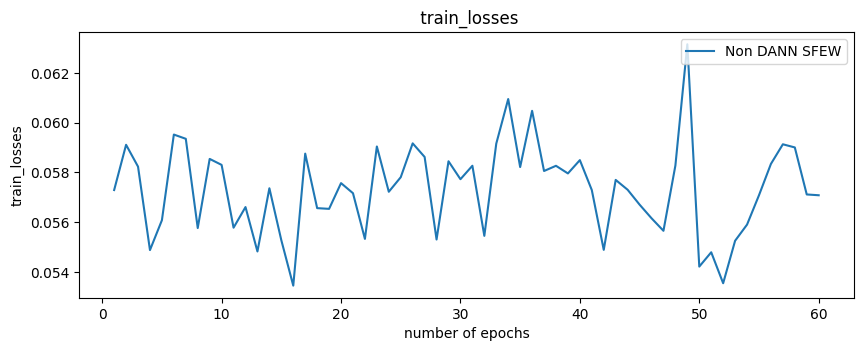

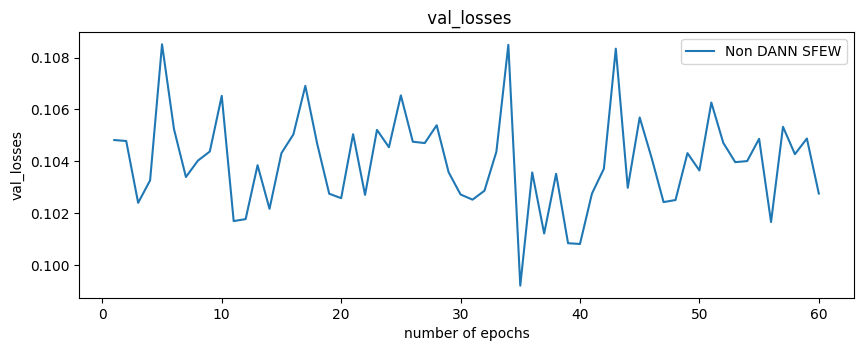

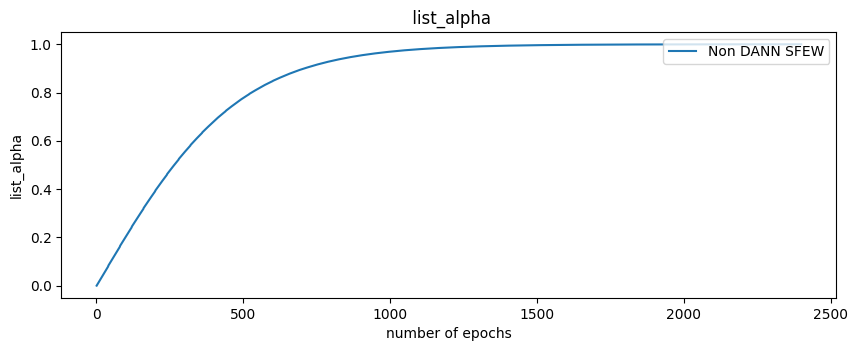

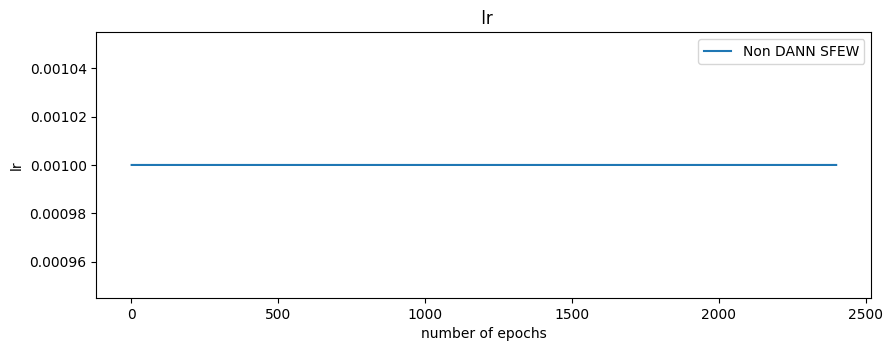

In [49]:
plot_loss_curves(dict_ewc_dann_losses,mode='train_losses')
plot_loss_curves(dict_ewc_dann_losses,mode='val_losses')
plot_loss_curves(dict_ewc_dann_losses,mode='list_alpha')
plot_loss_curves(dict_ewc_dann_losses,mode='lr')

### Saving DANN EWC Model

In [50]:
# ewc_dann_model_name = 'ewc_dann_sfew_expw_30_01.pt'
ewc_dann_model_name = f'ewc_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}.pt' #"ewc_dann_sfew_expw_" + str(time.strftime("%d_%m")) + ".pt"
print(ewc_dann_model_name)

from da_cv_fer.data_config import DataConfig
dataconfig_2 = DataConfig()
MODEL_DIR = dataconfig_2.MODEL_DIR


EWC_DANN_MODEL_DIR =  Path(os.path.join(MODEL_DIR, f'ewc_dann_{source_name}_{target_name}'))
# try:
#     EWC_DANN_SFEW_EXPW_DIR = Path(dataconfig_2.EWC_DANN_SFEW_EXPW_DIR)
# except:
#     EWC_DANN_SFEW_EXPW_DIR =Path(dataconfig_2.MODEL_DIR,"ewc_dann_sfew_expw")


if not EWC_DANN_MODEL_DIR.exists():
    # Create the directory
    EWC_DANN_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {EWC_DANN_MODEL_DIR} created successfully.')
else:
    print(f'Directory {EWC_DANN_MODEL_DIR} already exists.')

try:
    torch.save(ewc_dann_model.state_dict(), Path(EWC_DANN_MODEL_DIR,ewc_dann_model_name))
    print(f'{ewc_dann_model_name} SAVED at {Path(EWC_DANN_MODEL_DIR,ewc_dann_model_name)}!')
except:
    print(f'Problem in saving {ewc_dann_model_name}, NOT SAVED!')


ewc_dann_sfew_expw_14_02.pt
Directory /content/gdrive/MyDrive/CV_FER/models/ewc_dann_sfew_expw already exists.
ewc_dann_sfew_expw_14_02.pt SAVED at /content/gdrive/MyDrive/CV_FER/models/ewc_dann_sfew_expw/ewc_dann_sfew_expw_14_02.pt!
